<a href="https://colab.research.google.com/github/MAHDI-Imen/PACBayes/blob/main/BML2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model selection on Bayesian Neural Networks

The code of this notebook is inspired by the praticals of the course [MVA Master: Foundations of deep learning](https://thome.isir.upmc.fr/classes/MVA/index.html)

In [113]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

Here we are going to install and import everything we are going to need for this tutorial.

**Note**: *You can double-click the title of the collapsed cells (as the ones below) to expand them and read their content.*

In [2]:
#@title Import libs
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons
from IPython import display
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils import data
import torch.nn.functional as F
from torch.autograd import grad
import torch.distributions as dist

In [109]:
#@title Useful plot function
def plot_decision_boundary(model, X, Y, epoch, accuracy, model_type='classic',
                           nsamples=100, posterior=None, tloc=(-4,-7),
                           nbh=2, cmap='RdBu'):
    """ Plot and show learning process in classification """
    h = 0.02*nbh
    x_min, x_max = X[:,0].min() - 10*h, X[:,0].max() + 10*h
    y_min, y_max = X[:,1].min() - 10*h, X[:,1].max() + 10*h
    xx, yy = np.meshgrid(np.arange(x_min*2, x_max*2, h),
                         np.arange(y_min*2, y_max*2, h))

    test_tensor = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).type(torch.FloatTensor)
    model.eval()
    with torch.no_grad():
        if model_type=='classic':
            pred = model(test_tensor)
        elif model_type=='laplace':
            #Save original mean weight
            original_weight = model.state_dict()['fc.weight'].detach().clone()
            outputs = torch.zeros(nsamples, test_tensor.shape[0], 1)
            for i in range(nsamples):
                state_dict = model.state_dict()
                state_dict['fc.weight'] = torch.from_numpy(posterior[i].reshape(1,2))
                model.load_state_dict(state_dict)
                outputs[i] = net(test_tensor)

            pred = outputs.mean(0).squeeze()
            state_dict['fc.weight'] = original_weight
            model.load_state_dict(state_dict)

        elif model_type=='vi':
            outputs = torch.zeros(nsamples, test_tensor.shape[0], 1)
            for i in range(nsamples):
                outputs[i] = model(test_tensor)

            pred = outputs.mean(0).squeeze()

        elif model_type=='mcdropout':
            model.eval()
            model.training = True
            outputs = torch.zeros(nsamples, test_tensor.shape[0], 1)
            for i in range(nsamples):
                outputs[i] = model(test_tensor)

            pred = outputs.mean(0).squeeze()

    Z = pred.reshape(xx.shape).detach().numpy()

    plt.cla()
    ax.set_title('Classification Analysis')
    ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.25)
    ax.contour(xx, yy, Z, colors='k', linestyles=':', linewidths=0.7)
    ax.scatter(X[:,0], X[:,1], c=Y, cmap='Paired_r', edgecolors='k');
    ax.text(tloc[0], tloc[1], f'Epoch = {epoch+1}, Accuracy = {accuracy:.2%}', fontdict={'size': 12, 'fontweight': 'bold'})
    display.display(plt.gcf())
    display.clear_output(wait=True)

def plot_decision_boundary2(model, X, Y, epoch, accuracy, model_type='classic',
                           nsamples=100, posterior=None, tloc=(-4,-7),
                           nbh=2, cmap='RdBu'):
    """ Plot and show learning process in classification """
    h = 0.02*nbh
    x_min, x_max = X[:,0].min() - 10*h, X[:,0].max() + 10*h
    y_min, y_max = X[:,1].min() - 10*h, X[:,1].max() + 10*h
    xx, yy = np.meshgrid(np.arange(x_min*2, x_max*2, h),
                         np.arange(y_min*2, y_max*2, h))

    test_tensor = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).type(torch.FloatTensor)
    model.eval()
    with torch.no_grad():
        if model_type=='classic':
            pred = model(test_tensor)
        elif model_type=='laplace':
            #Save original mean weight
            original_weight = model.state_dict()['fc.weight'].detach().clone()
            outputs = torch.zeros(nsamples, test_tensor.shape[0], 1)
            for i in range(nsamples):
                state_dict = model.state_dict()
                state_dict['fc.weight'] = torch.from_numpy(posterior[i].reshape(1,2))
                model.load_state_dict(state_dict)
                outputs[i] = net(test_tensor)

            pred = outputs.mean(0).squeeze()
            state_dict['fc.weight'] = original_weight
            model.load_state_dict(state_dict)

        elif model_type=='vi':
            outputs = torch.zeros(nsamples, test_tensor.shape[0], 1)
            for i in range(nsamples):
                outputs[i] = model(test_tensor)

            pred = outputs.mean(0).squeeze()

        elif model_type=='mcdropout':
            model.eval()
            model.training = True
            outputs = torch.zeros(nsamples, test_tensor.shape[0], 1)
            for i in range(nsamples):
                outputs[i] = model(test_tensor)

            pred = outputs.mean(0).squeeze()

    Z = pred.reshape(xx.shape).detach().numpy()

    plt.cla()
    ax.set_title('Classification Analysis')
    ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.25)
    ax.contour(xx, yy, Z, colors='k', linestyles=':', linewidths=0.7)
    ax.scatter(X[:,0], X[:,1], c=Y, cmap='Paired_r', edgecolors='k');
    ax.text(tloc[0], tloc[1], f'Epoch = {epoch+1}, Accuracy = {accuracy:.2%}', fontdict={'size': 12, 'fontweight': 'bold'})
    display.display(plt.gcf())
    # display.clear_output(wait=True)


In [4]:
#@title Useful data generation function
def two_moons(num_samples, moon_radius=2.0, moon_var=0.02):
    """
    Creates two intertwined moons

    :param num_samples: number of samples to create in the dataset
    :param moon_radius: radius of the moons
    :param moon_var:    variance of the moons
    :return: X,  (num_samples, 2) matrix of 2-dimensional samples
             Y,  (num_samples, ) vector of "true" cluster assignment
    """
    X = np.zeros((num_samples, 2))

    for i in range(int(num_samples / 2)):
        r = moon_radius + 4 * i / num_samples
        t = i * 3 / num_samples * np.pi
        X[i, 0] = r * np.cos(t)
        X[i, 1] = r * np.sin(t)
        X[i + int(num_samples / 2), 0] = r * np.cos(t + np.pi)
        X[i + int(num_samples / 2), 1] = r * np.sin(t + np.pi)

    X = X + np.sqrt(moon_var) * np.random.normal(size=(num_samples, 2))
    Y = np.ones(num_samples)
    Y[:int(num_samples / 2) + 1] = 0
    return [X, Y.astype(int)]

In [102]:
PRIOR_SD = 0.03 #@param
NB_SAMPLES  = 100 #@param
WEIGHT_DECAY = 1e-2 #@param
TEXT_LOCATION = (-1.5, -6)

In this part, we will reimplement variational inference by hand with Pytorch tools. <br/><br/>

**Optimization problem**  
We define an approximating variational distribution $q_{\pmb{\theta}}(\pmb{w})$ parametrized by $\pmb{\theta}$ and minimize its Kullback-Leibler (KL) divergence with the unknown true posterior $p(\pmb{w} \vert \mathcal{D})$. This is equivalent to maximizing the **evidence lower bound (ELBO)** w.r.t to $q_{\pmb{\theta}}(\pmb{w})$:

$$ arg \max_{\pmb{\theta}}~ \mathbb{E}_{q_{\pmb{\theta}}(\pmb{w})} \big [\underbrace{\log p(\mathcal{D} \vert \pmb{w})}_{likelihood} \big ] - \underbrace{\textrm{KL}(q_{\pmb{\theta}}(\pmb{w})\vert\vert p(\pmb{w}))}_{regularization} $$
where we have a likelihood term  and the KL divergence between the prior and the variational distribution.

Let’s first rewrite the KL-divergence term:
$$ \textrm{KL}(q_{\pmb{\theta}}(\pmb{w})\vert\vert p(\pmb{w})) = \int q_{\pmb{\theta}} \log \frac{q_{\pmb{\theta}}(\pmb{w})}{p(\pmb{w})}d\pmb{w} = \mathbb{E}_{q_{\pmb{\theta}}(\pmb{w})}\big [\log q_{\pmb{\theta}}(\pmb{w}) - \log p(\pmb{w})\big ] $$
As for the likelihood term, the KL-divergence can be written as an expectation over the approximate distribution $q_{\pmb{\theta}}(\pmb{w})$.

By assuming that samples are *i.i.d*, maximizing the ELBO is equivalent to minimizing the following loss:
$$ \mathcal{L}_{\textrm{VI}}(\pmb{\theta}; \mathcal{D}) = - \sum_{n=1}^N \mathbb{E}_{q_{\pmb{\theta}}(\pmb{w})} \Big [ \log p(y_n \vert \pmb{x}_n, \pmb{w}) + \frac{1}{N} \big ( \log q_{\pmb{\theta}}(\pmb{w}) - \log p(\pmb{w}) \big ) \Big ] $$
The KL-divergence is not dependent on $\mathcal{D}$, and can therefore be computed at the moment of sampling $\pmb{w}$. <br/><br/>

**Monte Carlo estimator**  
Deriving those expectations can be some tedious mathematics, or maybe not even possible. Luckily we can get estimates of the mean by taking samples from $q_{\pmb{\theta}}(\pmb{w})$ and average over those results.

Even more simple, we can show that using only one sample is stil an unbiased gradient estimator. Hence, loss function simply boils down to minimzing at each step:

$$ \mathcal{L}_{\textrm{VI}}(\pmb{\theta}; \mathcal{D}) = - \sum_{n=1}^N \Big ( \log p(y_n \vert \pmb{x}_n, \pmb{w}_s) + \frac{1}{N} \big ( \log q_{\pmb{\theta}}(\pmb{w}_s) - \log p(\pmb{w}_s) \big ) \Big )$$
where $\pmb{w}_s \sim q_{\pmb{\theta}}$ is a sample from the variational distribution. <br/><br/>

**Mean-field approximation**  
For simplicity, we assume a factorisation over the weights on each layer:
$$ q_{\pmb{\theta}}(\pmb{w}) = \prod_{l=1}^L q_{\pmb{\theta}}(\pmb{W}_l) = \prod_{l=1}^L \mathcal{N}(\pmb{W}_l; \pmb{\mu}_l, \pmb{\Sigma}^2_l) $$
As we chose a Gaussian prior $p(\pmb{W}_l)$, we also defined here $q_{\pmb{\theta}}(\pmb{W}_l)$ as a Gaussian distribution for its conjugate properties.For modelisation purposes, we take $q_{\pmb{\theta}}(\pmb{W}_l)$ to be isotropic, i.e. $\pmb{\Sigma}_l$ is diagonal.
<br/><br/>

**Reparametrization trick**  
If we start taking samples from $q_{\pmb{\theta}}$, we leave the deterministic world, and the gradient can not flow through the model anymore. We avoid this problem by reparameterizing the samples $\pmb{w}_{l,s} \sim \mathcal{N}(\pmb{\mu}_{l}, \pmb{\Sigma}_{l}^2)$ from the distribution.

Instead of sampling directly from the variational distribution, we sample from a centered isotropic multivariate Gaussian and recreate samples from the variational distribution. Now the stochasticity of $\pmb{\varepsilon}$ is external and will not prevent the flow of gradients.
$$ \pmb{w}_{l,s} = \pmb{\mu}_{l}+ \pmb{\Sigma}_{l}\odot\pmb{\varepsilon}_s$$
where $\pmb{\varepsilon}_s \sim \mathcal{N}(0,\pmb{I}_l)$, with $\pmb{I}_l \in \mathbb{R}^l$ the identity vector of size $l$.
<br/><br/>  

**Predictive distribution**  
For a new sample $\pmb{x^*}$, the predictive distribution can be approximated using **Monte Carlo sampling**:
\begin{equation}
p(\mathbf{y} =1|\pmb{x}^*,\mathcal{D}) \approx \int p(\mathbf{y} = 1|x^*,w)q_\theta^*(w) \approx \frac{1}{S} \sum_{s=1}^S p(\mathbf{y}=1|\pmb{x}^*,\pmb{w}_s)
\end{equation}
where $\pmb{w}_s \sim q^*_{\pmb{\theta}}$ are samples from the optimum variational distribution.

In [114]:
#@title Variational Layer
class LinearVariational(nn.Module):
    """
    Mean field approximation of nn.Linear
    """
    def __init__(self, input_size, output_size, accumulated_kl_div, prior_sd = PRIOR_SD):
        super().__init__()
        self.accumulated_kl_div = accumulated_kl_div
        self.prior_sd = prior_sd

        self.w_mu = nn.Parameter( torch.zeros(input_size,output_size))
        self.w_rho = nn.Parameter( torch.ones(input_size,output_size))
        self.b_mu = nn.Parameter(torch.zeros(output_size))
        self.b_rho = nn.Parameter(torch.ones(output_size))

    def sampling(self, mu, rho):
        "Sample weights using the reparametrization trick"

        return mu + torch.log(1 + torch.exp(rho)) * torch.randn_like(mu)

    def kl_divergence(self, z, mu_theta, rho_theta, prior_sd=PRIOR_SD):
        prior_sd = self.prior_sd
        "Computing the KL-divergence term for these weight's parameters"
        log_prior = dist.Normal(0, prior_sd).log_prob(z)
        log_p_q = dist.Normal(mu_theta, torch.log(1 + torch.exp(rho_theta))).log_prob(z)
        return (log_p_q - log_prior).sum() / X.shape[0]

    def forward(self, x):
        "Usual forward function for pytorch layer"
        w, b = self.sampling(self.w_mu, self.w_rho), self.sampling(self.b_mu, self.b_rho)

        out = x @ w + b

        # Compute KL-div loss for training
        self.accumulated_kl_div[0] += self.kl_divergence(w, self.w_mu, self.w_rho)
        self.accumulated_kl_div[0] += self.kl_divergence(b, self.b_mu, self.b_rho)

        return out

In [115]:
#@title Variational MLP

class VariationalMLP(nn.Module):
    def __init__(self, input_size, hidden_size, prior_sd = PRIOR_SD):
        super().__init__()
        self.accumulated_kl_div = np.zeros(1)


        # ============ YOUR CODE HERE ============
        # Define a variational MLP with 1 hidden layer and ReLU activation

        self.mlp = nn.Sequential(LinearVariational(input_size,
                                                   hidden_size,
                                                   self.accumulated_kl_div,
                                                   prior_sd = prior_sd),
                                 nn.ReLU(),
                                 LinearVariational(hidden_size,
                                                   1,
                                                   self.accumulated_kl_div,
                                                   prior_sd = prior_sd))

    def reset_kl_div(self):
        self.accumulated_kl_div[0] = 0

    def forward(self, x):

        x = self.mlp(x)
        return torch.sigmoid(x)

In [8]:
def elbo(input, target, model):
    negative_log_likelihood = -dist.Binomial(logits=input).log_prob(target).sum()
    return negative_log_likelihood + model.accumulated_kl_div[0] / input.shape[0]

def get_negative_log_likelihood(input, target):
    negative_log_likelihood = -dist.Binomial(logits=input).log_prob(target).sum()
    return negative_log_likelihood

def get_kl(input, model):
    return model.accumulated_kl_div[0] / input.shape[0]

def get_all(input, target, model):
  negative_log_likelihood = -dist.Binomial(logits=input).log_prob(target).sum()
  kl_value = model.accumulated_kl_div[0] / input.shape[0]
  elbo_value = negative_log_likelihood + model.accumulated_kl_div[0] / input.shape[0]
  return elbo_value, negative_log_likelihood, kl_value

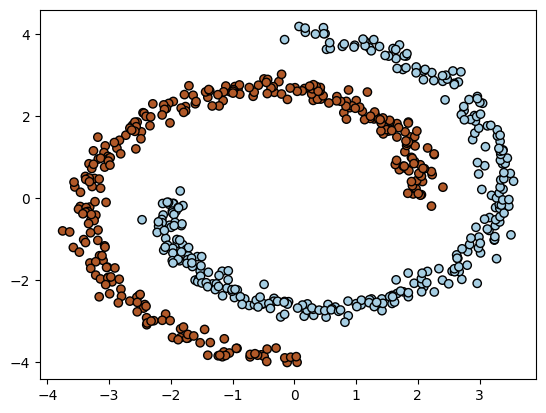

In [9]:
#@title Load two moons dataset
# X, y = make_moons (n_samples=1000, noise=NOISE_MOON)
X, y = two_moons(num_samples=600)
X, y = torch.from_numpy(X), torch.from_numpy(y)
X, y = X.type(torch.float), y.type(torch.float)
torch_train_dataset = data.TensorDataset(X,y) # create your datset
train_dataloader = data.DataLoader(torch_train_dataset, batch_size=len(torch_train_dataset))
N_DIM = X.shape[1]

# Visualize dataset
plt.scatter(X[:,0], X[:,1], c=y, cmap='Paired_r', edgecolors='k')
plt.show()

In [ ]:
%%script false --no-raise-error

#@title Train a Variational MLP
var_net = VariationalMLP(input_size=X.shape[1], hidden_size=2,prior_sd = 0.03)
var_net.train()
optimizer = torch.optim.Adam(var_net.parameters(), lr=0.1, weight_decay=WEIGHT_DECAY)
fig, ax = plt.subplots(figsize=(7,7))

for epoch in range(10_000):  # loop over the dataset multiple times
      # zero the parameter gradients
      optimizer.zero_grad()
      var_net.reset_kl_div()

      # forward + backward + optimize
      output = var_net(X).squeeze()
      loss = elbo(output, y, var_net)
      loss.backward()
      optimizer.step()

      # For plotting and showing learning process at each epoch
      if (epoch+1)%50==0:
          # Computing prediction for visualization purpose
          preds = torch.zeros(NB_SAMPLES, X.shape[0], 1)
          for i in range(NB_SAMPLES):
              preds[i] = var_net(X)
          pred = preds.mean(0).squeeze()
          accuracy = ((pred>=0.5) == y).float().mean()

          plot_decision_boundary(var_net, X, y, epoch, accuracy, model_type='vi', tloc=TEXT_LOCATION)

In [90]:
negative_log_likelihoodss = []
klss = []

hidden_size = 1


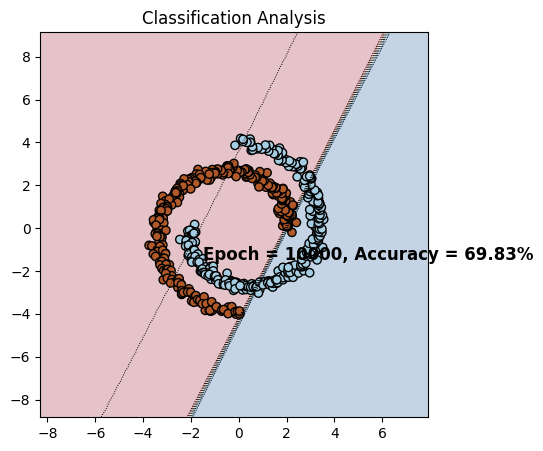

hidden_size = 2


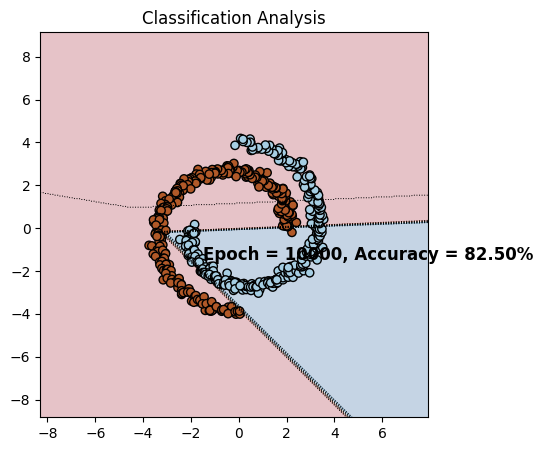

hidden_size = 3


In [ ]:
negative_log_likelihoods = []
kls = []
hidden_sizes = [1,2,3,4,5,10,15] #[16,128,256,512,1024]
for hidden_size in hidden_sizes:
  print(f'hidden_size = {hidden_size}')
  var_net = VariationalMLP(input_size=X.shape[1], hidden_size=hidden_size, prior_sd = 0.03)
  var_net.train()
  optimizer = torch.optim.Adam(var_net.parameters(), lr=0.1, weight_decay=WEIGHT_DECAY)
  fig, ax = plt.subplots(figsize=(5,5))
  for epoch in range(10_000):  # loop over the dataset multiple times
      # zero the parameter gradients
      optimizer.zero_grad()
      var_net.reset_kl_div()

      # forward + backward + optimize
      output = var_net(X).squeeze()
      loss = elbo(output, y, var_net)
      loss.backward()
      optimizer.step()


  with torch.no_grad():
    ##
    preds = torch.zeros(NB_SAMPLES, X.shape[0], 1)
    for i in range(NB_SAMPLES):
        preds[i] = var_net(X)
    pred = preds.mean(0).squeeze()
    accuracy = ((pred>=0.5) == y).float().mean()
    plot_decision_boundary2(var_net, X, y, epoch, accuracy, model_type='vi', tloc=TEXT_LOCATION)

    ##
    tot_kl = 0.
    tot_negative_log_likelihood = 0.

    var_net.reset_kl_div()
    for i in range(NB_SAMPLES):
      output = var_net(X).squeeze()
      elbo_value,negative_log_likelihood,kl = get_all(output,y,var_net)
      tot_kl += kl.item()
      tot_negative_log_likelihood += negative_log_likelihood.item()
    negative_log_likelihoods.append(tot_negative_log_likelihood / NB_SAMPLES)
    kls.append(tot_kl / NB_SAMPLES)
negative_log_likelihoodss.append(negative_log_likelihoods)
klss.append(kls)
plt.close()

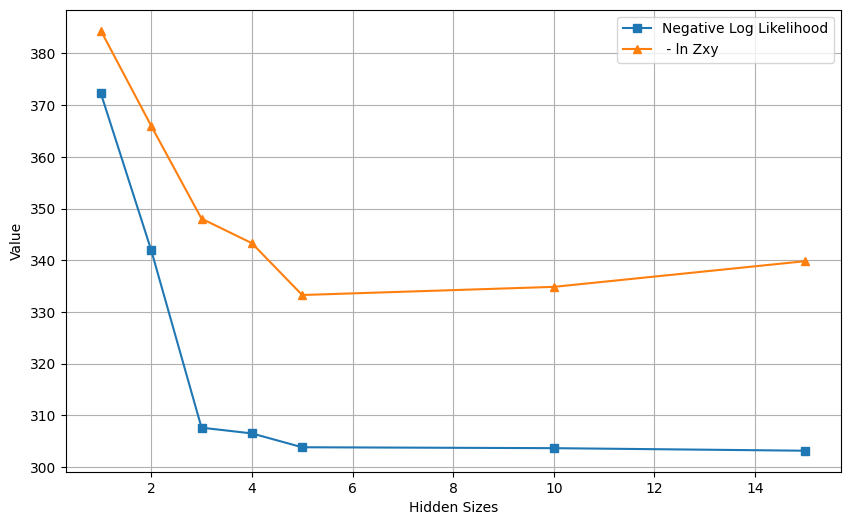

In [103]:
# Plotting
plt.figure(figsize=(10, 6))

# plt.plot(hidden_sizes, np.array(kls).T, label="KL", marker='o')
plt.plot(hidden_sizes, np.array(negative_log_likelihoods).T, label="Negative Log Likelihood", marker='s')
plt.plot(hidden_sizes, np.array(kls).T + np.array(negative_log_likelihoods).T, label=" - ln Zxy", marker='^')

# Add details and style
# plt.title('Comparison of KL, Negative Log Likelihood, and Z')
plt.xlabel('Hidden Sizes')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Show plot
plt.show()